In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
register_matplotlib_converters()

# Generate some data

### $y$<sub>t</sub> = 50 + 0.4ϵ<sub>t-1</sub> + 0.3ϵ<sub>t-2</sub> + ϵ<sub>t</sub>
### ϵ<sub>t</sub> ~ N(0,1)

In [2]:
errors = np.random.normal(0, 1, 400)

In [3]:
date_index = pd.date_range(start='9/1/2019', end='1/1/2020')

In [4]:
mu = 50
series = []
for t in range(1,len(date_index)+1):
    series.append(mu + 0.4*errors[t-1] + 0.3*errors[t-2] + errors[t])

In [5]:
series = pd.Series(series, date_index)
series = series.asfreq(pd.infer_freq(series.index))
series

2019-09-01    50.053601
2019-09-02    49.632030
2019-09-03    49.369645
2019-09-04    50.278808
2019-09-05    48.884447
                ...    
2019-12-28    50.118211
2019-12-29    48.344147
2019-12-30    47.795584
2019-12-31    47.059990
2020-01-01    49.248207
Freq: D, Length: 123, dtype: float64

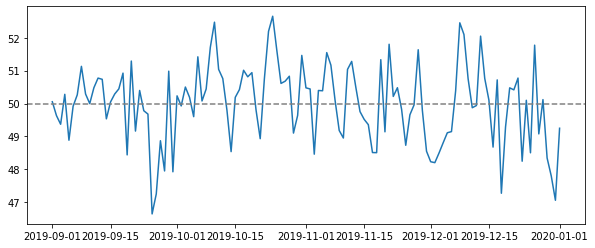

In [6]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.axhline(mu, linestyle='--', color='grey')

# ACF

<BarContainer object of 10 artists>

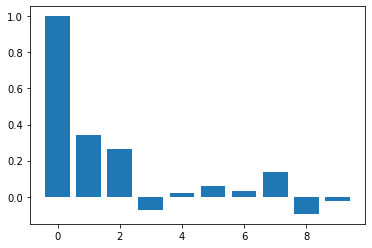

In [7]:
acf_vals = acf(series)
num_lags = 10
plt.bar(range(num_lags), acf_vals[:num_lags])

# PACF

<BarContainer object of 20 artists>

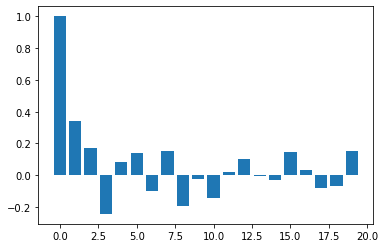

In [8]:
pacf_vals = pacf(series)
num_lags = 20
plt.bar(range(num_lags), pacf_vals[:num_lags])

# Get training and testing sets

In [9]:
train_end = datetime(2019,12,30)
test_end = datetime(2020,1,1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1):test_end]

# Fit MA model

In [10]:
# create the model
model = ARIMA(train_data, order=(0,0,1))

In [11]:
#fit the model
model_fit = model.fit()

In [12]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -186.222
Date:                Tue, 28 Nov 2023   AIC                            378.443
Time:                        15:13:45   BIC                            386.831
Sample:                    09-01-2019   HQIC                           381.850
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0162      0.127    394.672      0.000      49.768      50.265
ma.L1          0.2115      0.080      2.643      0.008       0.055       0.368
sigma2         1.2710      0.170      7.478      0.0

# Predicted model

In [13]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [14]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
predictions

2019-12-31    49.625004
2020-01-01    50.016197
Freq: D, Name: predicted_mean, dtype: float64

In [15]:
residuals = test_data - predictions

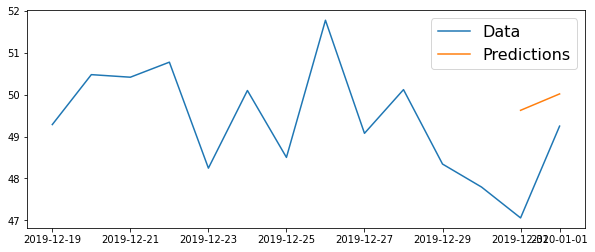

In [16]:
plt.figure(figsize=(10,4))

plt.plot(series[-14:])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

In [17]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.035


In [18]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1.893291864407268
